In [95]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

import datetime

In [2]:
df = pd.read_csv('../data/interim/salary_skill_cleaned.csv')
df.head()

,Unnamed: 0,occupation,skill,importance,location,state,salary
0,0,Chief Executives,Reading Comprehension,4.12,Aguadilla-Isabela,PR,92200.0
1,1,Chief Executives,Reading Comprehension,4.12,Akron,OH,204420.0
2,2,Chief Executives,Reading Comprehension,4.12,Albany,GA,121260.0
3,3,Chief Executives,Reading Comprehension,4.12,Albany-Schenectady-Troy,NY,155870.0
4,4,Chief Executives,Reading Comprehension,4.12,Allentown-Bethlehem-Easton,PA,215910.0


In [3]:
skills = df.pivot_table(values='importance',index=['occupation', 'state', 'salary'],columns='skill').reset_index()
skills.head()

skill,occupation,state,salary,Active Learning,Active Listening,Complex Problem Solving,Coordination,Critical Thinking,Equipment Maintenance,Equipment Selection,...,Science,Service Orientation,Social Perceptiveness,Speaking,Systems Analysis,Systems Evaluation,Technology Design,Time Management,Troubleshooting,Writing
0,Accountants and Auditors,AK,71610.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75
1,Accountants and Auditors,AK,81170.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75
2,Accountants and Auditors,AL,58570.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75
3,Accountants and Auditors,AL,60400.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75
4,Accountants and Auditors,AL,62120.0,3.31,3.94,3.44,3.06,3.88,1.0,1.0,...,1.88,3.0,3.06,3.81,3.19,2.94,1.75,3.25,1.12,3.75


In [4]:
skills.shape

(136041, 38)

In [5]:
# Drop Installation, Equipment Selection, Equipment Maintenance, and Repairing (from EDA)
skills.drop(columns=['Installation', 'Equipment Selection', 'Equipment Maintenance', 'Repairing'], inplace=True)
skills.set_index('occupation', inplace=True)
skills.columns

Index(['state', 'salary', 'Active Learning', 'Active Listening',
       'Complex Problem Solving', 'Coordination', 'Critical Thinking',
       'Instructing', 'Judgment and Decision Making', 'Learning Strategies',
       'Management of Financial Resources', 'Management of Material Resources',
       'Management of Personnel Resources', 'Mathematics', 'Monitoring',
       'Negotiation', 'Operation and Control', 'Operations Analysis',
       'Operations Monitoring', 'Persuasion', 'Programming',
       'Quality Control Analysis', 'Reading Comprehension', 'Science',
       'Service Orientation', 'Social Perceptiveness', 'Speaking',
       'Systems Analysis', 'Systems Evaluation', 'Technology Design',
       'Time Management', 'Troubleshooting', 'Writing'],
      dtype='object', name='skill')

In [6]:
skills.shape

(136041, 33)

In [7]:
# One-hot encode states
skills_coded = pd.get_dummies(skills, 
               columns=['state'], 
               drop_first=True, 
               prefix='C')
skills_coded.head()

,salary,Active Learning,Active Listening,Complex Problem Solving,Coordination,Critical Thinking,Instructing,Judgment and Decision Making,Learning Strategies,Management of Financial Resources,...,C_SD,C_TN,C_TX,C_UT,C_VA,C_VT,C_WA,C_WI,C_WV,C_WY
occupation,,,,,,,,,,,,,,,,,,,,,
Accountants and Auditors,71610.0,3.31,3.94,3.44,3.06,3.88,2.88,3.5,2.94,2.56,...,0,0,0,0,0,0,0,0,0,0
Accountants and Auditors,81170.0,3.31,3.94,3.44,3.06,3.88,2.88,3.5,2.94,2.56,...,0,0,0,0,0,0,0,0,0,0
Accountants and Auditors,58570.0,3.31,3.94,3.44,3.06,3.88,2.88,3.5,2.94,2.56,...,0,0,0,0,0,0,0,0,0,0
Accountants and Auditors,60400.0,3.31,3.94,3.44,3.06,3.88,2.88,3.5,2.94,2.56,...,0,0,0,0,0,0,0,0,0,0
Accountants and Auditors,62120.0,3.31,3.94,3.44,3.06,3.88,2.88,3.5,2.94,2.56,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Define X and y
X = skills_coded.drop(columns=['salary'])
y = skills_coded['salary']

# Train/Test Split

In [9]:
len(X) * .7, len(X) * .3

(95228.7, 40812.299999999996)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)

In [11]:
X_train.shape, X_test.shape

((95228, 82), (40813, 82))

In [12]:
y_train.shape, y_test.shape

((95228,), (40813,))

In [13]:
X_train.dtypes

Active Learning            float64
Active Listening           float64
Complex Problem Solving    float64
Coordination               float64
Critical Thinking          float64
                            ...   
C_VT                         uint8
C_WA                         uint8
C_WI                         uint8
C_WV                         uint8
C_WY                         uint8
Length: 82, dtype: object

In [14]:
X_test.dtypes

Active Learning            float64
Active Listening           float64
Complex Problem Solving    float64
Coordination               float64
Critical Thinking          float64
                            ...   
C_VT                         uint8
C_WA                         uint8
C_WI                         uint8
C_WV                         uint8
C_WY                         uint8
Length: 82, dtype: object

In [15]:
# Standardize features
scaler = MinMaxScaler()
scaler.fit(X_train)
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)

# Baseline Model

In [16]:
# Use the mean as a baseline model
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_tr_scaled, y_train)
dumb_reg.constant_

array([[61044.17954803]])

In [17]:
# Predictions, train and test
y_tr_pred = dumb_reg.predict(X_tr_scaled)
y_te_pred = dumb_reg.predict(X_te_scaled)

In [18]:
# R_squared error
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -1.7130880713978058e-06)

In [19]:
# MAE, train and test
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(24540.85650772087, 24323.158925754055)

In [20]:
# MSE, train and test
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(1074915663.9517589, 1054016656.7855808)

# Linear Model 

In [21]:
# Linear Regression
lm = LinearRegression().fit(X_tr_scaled, y_train)

In [22]:
# Predictions, train and test
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

In [23]:
# R_squared error
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.6070916246133975, 0.6037890333780656)

In [24]:
# MAE, train and test
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(14256.847093961414, 14250.643105413412)

In [25]:
# MSE, train and test
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(422343367.20089674, 417612243.01408273)

# Linear Regression (pipeline)

In [26]:
# Define pipeline (linear regression)
pipeline = make_pipeline(
    MinMaxScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [27]:
# Fit pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x000001FE8C1075E0>)),
                ('linearregression', LinearRegression())])

In [28]:
# Predictions, train and test
y_tr_pred = pipeline.predict(X_train)
y_te_pred = pipeline.predict(X_test)

In [29]:
# R_squared error
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.5096029816332991, 0.5078183573774487)

In [30]:
# MAE, train and test
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(15749.839639383224, 15712.334057097087)

In [31]:
# MSE, train and test
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(527135436.5976052, 518766760.79510725)

In [32]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'minmaxscaler', 'selectkbest', 'linearregression', 'minmaxscaler__copy', 'minmaxscaler__feature_range', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize'])

## Cross-validate

In [33]:
cv = cross_validate(pipeline, X_train, y_train, cv=5)

In [34]:
cv_scores = cv['test_score']
cv_scores

array([0.50477401, 0.51306317, 0.51152779, 0.51006312, 0.50792524])

In [35]:
np.mean(cv_scores), np.std(cv_scores)

(0.5094706663722525, 0.002896058875524491)

## Hyperparameter search using GridSearchCV

In [36]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [37]:
lr_grid_cv = GridSearchCV(pipeline, param_grid=grid_params, cv=5, n_jobs=-1)

In [38]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001FE8C1075E0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [39]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [40]:
lr_grid_cv.best_params_

{'selectkbest__k': 82}

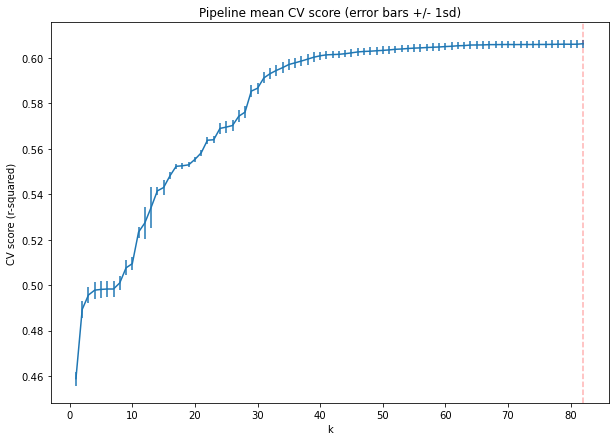

In [41]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 7))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.3)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [42]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [43]:
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
most_important = pd.Series(coefs, index=features).sort_values(ascending=False)
most_important[:15]

Management of Financial Resources    54338.626480
Science                              41192.035716
Judgment and Decision Making         36809.624092
Persuasion                           35218.222749
Critical Thinking                    28431.693271
Active Learning                      22685.603616
Reading Comprehension                22369.108770
Management of Personnel Resources    21606.376076
Time Management                      19296.807846
Monitoring                           15198.278796
Systems Evaluation                   13761.458470
Speaking                             11095.404170
Complex Problem Solving               5710.209510
C_DC                                  4924.494524
C_CA                                  2872.364145
dtype: float64

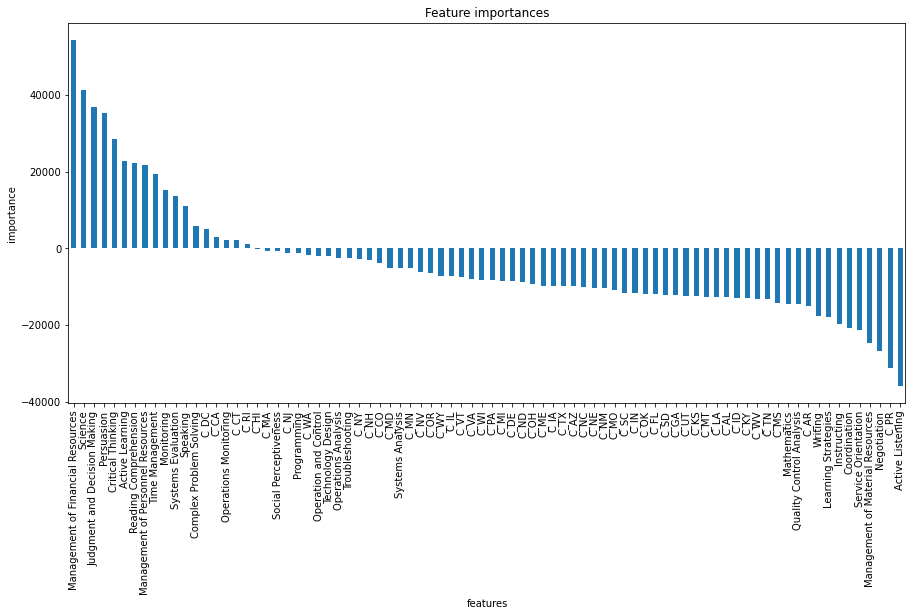

In [44]:
plt.subplots(figsize=(15, 7))
most_important.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importances');

# Random Forest Model

In [47]:
# Define pipeline (random forest)
rf_pipeline = make_pipeline(
    MinMaxScaler(),
    RandomForestRegressor(random_state=42)
)

In [48]:
# Fit pipeline
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [49]:
# Predictions, train and test
y_tr_pred = rf_pipeline.predict(X_train)
y_te_pred = rf_pipeline.predict(X_test)

In [50]:
# R_squared error
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.939683873694745, 0.8876193756269025)

In [51]:
# MAE, train and test
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(5115.563486071196, 7007.167669523709)

In [52]:
# MSE, train and test
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(64834748.95441122, 118450847.07247521)

In [53]:
rf_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'minmaxscaler', 'randomforestregressor', 'minmaxscaler__copy', 'minmaxscaler__feature_range', 'randomforestregressor__bootstrap', 'randomforestregressor__ccp_alpha', 'randomforestregressor__criterion', 'randomforestregressor__max_depth', 'randomforestregressor__max_features', 'randomforestregressor__max_leaf_nodes', 'randomforestregressor__max_samples', 'randomforestregressor__min_impurity_decrease', 'randomforestregressor__min_impurity_split', 'randomforestregressor__min_samples_leaf', 'randomforestregressor__min_samples_split', 'randomforestregressor__min_weight_fraction_leaf', 'randomforestregressor__n_estimators', 'randomforestregressor__n_jobs', 'randomforestregressor__oob_score', 'randomforestregressor__random_state', 'randomforestregressor__verbose', 'randomforestregressor__warm_start'])

## Cross-validate

In [54]:
rf_cv = cross_validate(rf_pipeline, X_train, y_train, cv=5)

In [55]:
rf_cv_scores = rf_cv['test_score']
rf_cv_scores

array([0.88380804, 0.89273923, 0.88879779, 0.88759428, 0.88469459])

In [56]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.8875267860497988, 0.0031824517006334503)

## Hyperparameter search using GridSearchCV

In [57]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'minmaxscaler': [MinMaxScaler(), None]
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'minmaxscaler': [MinMaxScaler(), None]}

In [58]:
rf_grid_cv = GridSearchCV(rf_pipeline, param_grid=grid_params, cv=5, n_jobs=-1)

In [59]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'minmaxscaler': [MinMaxScaler(), None],
                         'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000]})

In [60]:
rf_grid_cv.best_params_

{'minmaxscaler': MinMaxScaler(), 'randomforestregressor__n_estimators': 784}

In [61]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.88416473, 0.89289263, 0.88928043, 0.88778966, 0.8849542 ])

In [62]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.8878163317960182, 0.0031444912701546045)

In [90]:
coefs = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
features = X_train.columns
most_important = pd.Series(coefs, index=features).sort_values(ascending=False)
most_important[:15]

Complex Problem Solving              0.408544
Critical Thinking                    0.127514
Management of Financial Resources    0.049370
Science                              0.047853
Systems Analysis                     0.031737
Monitoring                           0.026011
Systems Evaluation                   0.020215
Operations Analysis                  0.018728
Social Perceptiveness                0.015938
C_CA                                 0.013655
Reading Comprehension                0.012808
Mathematics                          0.012798
Operations Monitoring                0.011583
Service Orientation                  0.010476
Coordination                         0.010421
dtype: float64

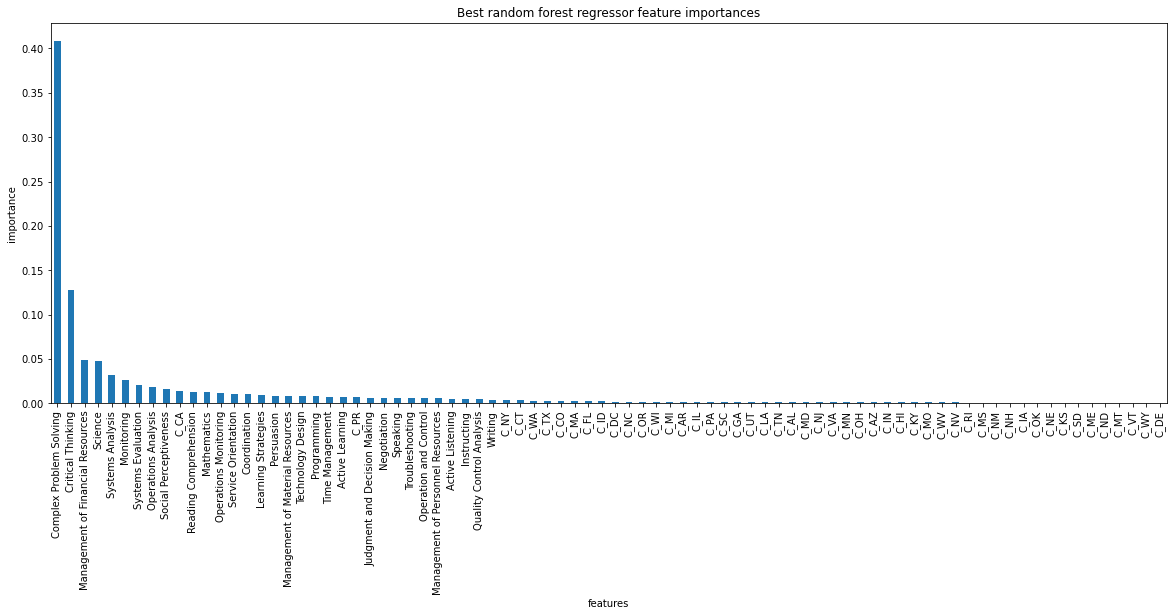

In [91]:
plt.subplots(figsize=(20, 7))
rf_feat_imps = pd.Series(coefs, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [92]:
best_model = rf_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [104]:
filename = '../models/skill_salary_model.sav'
pickle.dump(best_model, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8879258204606786
